##Data Prep and Setup

In [ ]:
import numpy as np
import pandas as pd
import json
import datetime

import re
import nltk
from nltk.corpus import stopwords

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
categories_df = pd.read_json('/content/drive/Shared drives/Google3F_AI_Studio/US_category_id.json')
categories_df = pd.json_normalize(categories_df['items'])[['id', 'snippet.title']]
categories_df = categories_df.rename(columns={'snippet.title': 'title'})

data_df = pd.read_csv('/content/drive/Shared drives/Google3F_AI_Studio/US_youtube_trending_data.csv')
data_df['publishedAt'] = pd.to_datetime(data_df['publishedAt'], dayfirst=True, format='ISO8601', utc=True)
data_df['trending_date'] = pd.to_datetime(data_df['trending_date'], dayfirst=True, format='ISO8601', utc=True)

# Add a day of the week column
data_df.loc[:, 'published_day_of_week'] = data_df['publishedAt'].dt.day_name()

import pandas as pd
# Convert 'categoryId' in data_df to string type so a join can be performed
data_df['categoryId'] = data_df['categoryId'].astype(str)
data_df = pd.merge(data_df, categories_df, left_on='categoryId', right_on='id', how='left')
data_df = data_df.rename(columns={'title_x': 'title', 'title_y': 'categoryName'})



# prompt: one-hot encode the published day of week column

# Create a OneHotEncoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Reshape the data before encoding
encoded_data = encoder.fit_transform(data_df[['published_day_of_week']])

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['published_day_of_week']))

# Concatenate the encoded DataFrame with the original DataFrame
data_df = pd.concat([data_df, encoded_df], axis=1)

# take the log first, then divide by days

# Calculate the difference between trending_date and publishedAt in days
data_df['days_since_published'] = (data_df['trending_date'] - data_df['publishedAt']).dt.days +2
# set the min days to 1 to prevent negatives in the place of +2


# data_df['days_since_published'] = data_df['days_since_published'].apply(lambda x: max(x, 1))
# this didn't work im not sure why


data_df['log_view_velocity'] = np.log(data_df['view_count'] +1) / data_df['days_since_published']
data_df['view_velocity'] = data_df['view_count']+1 / data_df['days_since_published']

data_df['log_days_since_published'] = np.log(data_df['days_since_published'])
data_df['square_days_since_published'] = data_df['days_since_published'] ** 2
data_df['sqrt_days_since_published'] = np.sqrt(data_df['days_since_published'])


# Calculate the mean of the 'view_velocity' column (or whichever column you want to use)
mean = data_df['view_velocity'].mean()

# Fill NaN values in 'data_df' with the calculated mean
data_df.fillna(value=mean, inplace=True)

In [ ]:
data_df.shape

(268787, 32)

In [ ]:
# prompt: list all the categories

print(data_df['categoryName'].unique())

['People & Blogs' 'Gaming' 'Entertainment' 'Music' 'Howto & Style'
 'Education' 'Comedy' 'Science & Technology' 'Film & Animation'
 'News & Politics' 'Sports' 'Travel & Events' 'Pets & Animals'
 'Autos & Vehicles' 'Nonprofits & Activism']


In [ ]:
data_df['log_view_velocity'].describe()

,log_view_velocity
count,268787.000000
mean,3.298111
std,1.651311
min,0.000000
25%,2.154144
50%,2.785231
75%,4.125472
max,18.021870


In [ ]:
data_df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,...,published_day_of_week_Sunday,published_day_of_week_Thursday,published_day_of_week_Tuesday,published_day_of_week_Wednesday,days_since_published,log_view_velocity,view_velocity,log_days_since_published,square_days_since_published,sqrt_days_since_published
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12 00:00:00+00:00,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,...,0.0,0.0,1.0,0.0,2,7.115336,1514614.5,0.693147,4,1.414214
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12 00:00:00+00:00,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,...,0.0,0.0,1.0,0.0,2,7.341660,2381688.5,0.693147,4,1.414214
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12 00:00:00+00:00,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,...,0.0,0.0,1.0,0.0,2,7.263949,2038853.5,0.693147,4,1.414214
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12 00:00:00+00:00,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,...,0.0,0.0,1.0,0.0,2,6.557943,496771.5,0.693147,4,1.414214
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12 00:00:00+00:00,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,...,0.0,0.0,1.0,0.0,2,6.966153,1123889.5,0.693147,4,1.414214


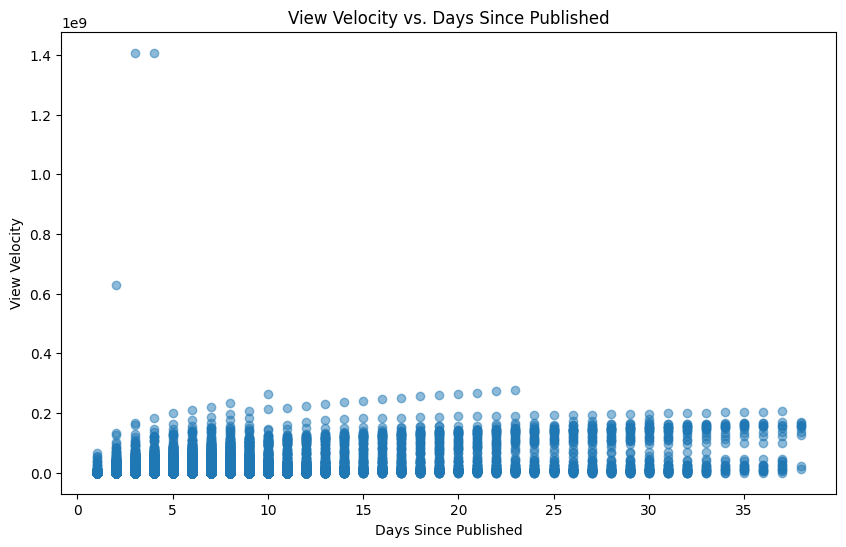

In [ ]:
# prompt: make a scatter plot of view velocity on the y axis vs day ssicne published on the x axis

plt.figure(figsize=(10, 6))
plt.scatter(data_df['days_since_published'], data_df['view_velocity'], alpha=0.5)
plt.xlabel('Days Since Published')
plt.ylabel('View Velocity')
plt.title('View Velocity vs. Days Since Published')
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Group by category and calculate the mean view velocity
category_view_velocity = data_df.groupby('categoryName')['view_velocity'].mean()

# Sort by view velocity in descending order and get the top 15 categories
top_15_categories = category_view_velocity.sort_values(ascending=False).head(15).index.tolist()

# Create a new column 'category_encoded' that assigns "Other" for categories not in top 15
data_df['category_encoded'] = data_df['categoryName'].apply(lambda x: x if x in top_15_categories else 'Other')

data_df['category_encoded'] = data_df['category_encoded'].astype(str)
# Perform one-hot encoding on the 'category_encoded' column
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_data = encoder.fit_transform(data_df[['category_encoded']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['category_encoded']))

# Concatenate the encoded DataFrame with the original DataFrame
data_df = pd.concat([data_df, encoded_df], axis=1)

# Optional: Drop the original 'categoryId' and 'category_encoded' columns if no longer needed
# data_df = data_df.drop(['categoryId', 'category_encoded'], axis=1)

# Check the updated DataFrame





In [ ]:
# prompt: one hot encode the top 20 channels, if a video's channel is not in that top 20, include it in a "other" cetegroy

#   TESTING WITH TOP 50 CHANNELS

# Group by channel title and calculate the mean view velocity
channel_view_velocity = data_df.groupby('channelTitle')['view_velocity'].mean()

# Sort by view velocity in descending order and get the top 20 channels
top_20_channels = channel_view_velocity.sort_values(ascending=False).head(90).index.tolist()

# Create a new column 'top_channel_category_20' and initialize it with 'Other'
data_df['top_channel_category_20'] = 'Other'

# Assign the channel name if it's in the top 20, otherwise keep it as 'Other'
data_df.loc[data_df['channelTitle'].isin(top_20_channels), 'top_channel_category_20'] = data_df['channelTitle']


# Perform one-hot encoding on the 'top_channel_category_20' column
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_data = encoder.fit_transform(data_df[['top_channel_category_20']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['top_channel_category_20']))

# Concatenate the encoded DataFrame with the original DataFrame
data_df = pd.concat([data_df, encoded_df], axis=1)

# Optional: Drop the original 'top_channel_category_20' column if no longer needed
# data_df = data_df.drop(['top_channel_category_20'], axis=1)

# Check the updated DataFrame
# print(data_df.head())


In [ ]:
# Split the tags column into a list of tags
data_df['tags_list'] = data_df['tags'].str.split('|')

# Flatten the list of tags into a single list
all_tags = [tag for tags in data_df['tags_list'] for tag in tags]

# Count the frequency of each tag
tag_counts = Counter(all_tags)

# Get the top twenty tags
top_twenty_tags = [tag for tag, count in tag_counts.most_common(20)]

# Count how many of the top 20 tags are present in each row and sum them
data_df['top_20_tag_count'] = data_df['tags_list'].apply(lambda tags: sum(1 for tag in tags if tag in top_twenty_tags))


In [ ]:
data_df.columns

Index(['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle',
       'categoryId', 'trending_date', 'tags', 'view_count', 'likes',
       ...
       'top_channel_category_20_That's Amazing Shorts',
       'top_channel_category_20_The Pixel Kingdom',
       'top_channel_category_20_Trickshot CEO',
       'top_channel_category_20_Viacom18 Studios',
       'top_channel_category_20_YRF',
       'top_channel_category_20_Zach King Shorts',
       'top_channel_category_20_Zee Music Company',
       'top_channel_category_20_Zee Studios', 'tags_list', 'top_20_tag_count'],
      dtype='object', length=102)

In [ ]:
# prompt: make a list containging all columns titles with 'top_20_channel_category'

top_20_channel_category_columns = [col for col in data_df.columns if 'top_channel_category_20' in col]
print(top_20_channel_category_columns)

top_20_channel_category_columns.remove('top_channel_category_20')
print(top_20_channel_category_columns)


['top_channel_category_20', 'top_channel_category_20_5-Minute Crafts FAMILY', 'top_channel_category_20_AdeleVEVO', 'top_channel_category_20_Alex & Ksyu', 'top_channel_category_20_BIGBANG', 'top_channel_category_20_BLACKPINK', 'top_channel_category_20_Big Hit Labels', 'top_channel_category_20_Bizarrap', 'top_channel_category_20_CHANDAN ART ACADEMY', 'top_channel_category_20_DaFuq!?Boom!', 'top_channel_category_20_Dan Rhodes', 'top_channel_category_20_Desi Music Factory', 'top_channel_category_20_Dharma Productions', 'top_channel_category_20_Discord', 'top_channel_category_20_Dr.Harrsha Artist', 'top_channel_category_20_FFUNTV', 'top_channel_category_20_Fortnite Fun TV', 'top_channel_category_20_Fruit Satisfying', 'top_channel_category_20_GuzNurik', 'top_channel_category_20_Haarika & Hassine Creations', 'top_channel_category_20_Hombale Films', 'top_channel_category_20_ISRO Official', 'top_channel_category_20_JANNA_Sega', 'top_channel_category_20_Jessi & Sean', 'top_channel_category_20_Ji

In [ ]:
# !pip install nltk
import nltk
import re
from collections import Counter
from nltk.corpus import stopwords

# Download the 'stopwords' resource
nltk.download('stopwords')

# Combine all titles into a single string
all_titles = ' '.join(data_df['title'].astype(str))

# Remove punctuation and convert to lowercase
all_titles = re.sub(r'[^\w\s]', '', all_titles).lower()

# Tokenize the string into words
words = all_titles.split()

# Remove stop words
stop_words = set(stopwords.words('english'))
words = [word for word in words if word not in stop_words]

# Count the frequency of each word
word_counts = Counter(words)

# Get the top 100 most frequent words
top_100_words = [word for word, count in word_counts.most_common(100)]

# Function to count the number of top 150 words in a title
def count_top_words(title):
  title_words = re.sub(r'[^\w\s]', '', title).lower().split()
  count = sum(1 for word in title_words if word in top_100_words)
  return count

# Apply the function to the 'title' column
data_df['top_100_words_count_title'] = data_df['title'].apply(count_top_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
features = [ 'published_day_of_week_Friday',
       'published_day_of_week_Monday', 'published_day_of_week_Saturday',
       'published_day_of_week_Sunday', 'published_day_of_week_Thursday',
       'published_day_of_week_Tuesday', 'published_day_of_week_Wednesday',
       'days_since_published',
       'log_days_since_published', 'square_days_since_published',
       'sqrt_days_since_published',
       'category_encoded_Autos & Vehicles', 'category_encoded_Comedy',
       'category_encoded_Education', 'category_encoded_Entertainment',
       'category_encoded_Film & Animation', 'category_encoded_Gaming',
       'category_encoded_Howto & Style', 'category_encoded_Music',
       'category_encoded_News & Politics', 'category_encoded_People & Blogs',
       'category_encoded_Pets & Animals',
       'category_encoded_Science & Technology', 'category_encoded_Sports',
       'category_encoded_Travel & Events', 'top_20_tag_count', 'top_100_words_count_title'
             ] + top_20_channel_category_columns

In [ ]:
# prompt: normalize days since published, square days since publisehd, log days since published

from sklearn.preprocessing import MinMaxScaler

# Create a scaler object
scaler = MinMaxScaler()

# Select the columns you want to normalize
columns_to_normalize = ['days_since_published', 'square_days_since_published', 'log_days_since_published', 'sqrt_days_since_published']

# Fit the scaler to your data and transform it
data_df[columns_to_normalize] = scaler.fit_transform(data_df[columns_to_normalize])


In [ ]:
data_df[['days_since_published', 'log_days_since_published', 'sqrt_days_since_published']].describe()

,days_since_published,log_days_since_published,sqrt_days_since_published
count,268787.000000,268787.000000,268787.000000
mean,0.112493,0.422631,0.235092
std,0.069161,0.126686,0.098721
min,0.000000,0.000000,0.000000
25%,0.054054,0.302017,0.141749
50%,0.108108,0.442447,0.239343
75%,0.135135,0.492568,0.280669
max,1.000000,1.000000,1.000000


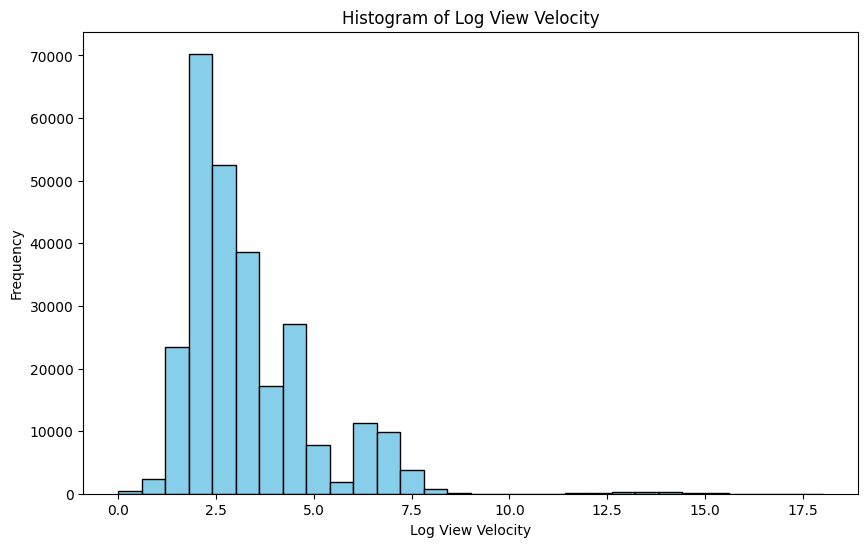

In [ ]:
# prompt: graph a histogram of the spread of log view velocity

plt.figure(figsize=(10, 6))
plt.hist(data_df['log_view_velocity'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Log View Velocity')
plt.xlabel('Log View Velocity')
plt.ylabel('Frequency')
plt.show()


## Model Training

[0]	validation_0-rmse:1.30837
[1]	validation_0-rmse:1.11965
[2]	validation_0-rmse:0.96016
[3]	validation_0-rmse:0.82560
[4]	validation_0-rmse:0.71253
[5]	validation_0-rmse:0.61800
[6]	validation_0-rmse:0.53922
[7]	validation_0-rmse:0.47385
[8]	validation_0-rmse:0.42029
[9]	validation_0-rmse:0.37672
[10]	validation_0-rmse:0.34169
[11]	validation_0-rmse:0.31366
[12]	validation_0-rmse:0.29168
[13]	validation_0-rmse:0.27457
[14]	validation_0-rmse:0.26131
[15]	validation_0-rmse:0.25144
[16]	validation_0-rmse:0.24379
[17]	validation_0-rmse:0.23806
[18]	validation_0-rmse:0.23389
[19]	validation_0-rmse:0.23081
[20]	validation_0-rmse:0.22848
[21]	validation_0-rmse:0.22675
[22]	validation_0-rmse:0.22551
[23]	validation_0-rmse:0.22459
[24]	validation_0-rmse:0.22388
[25]	validation_0-rmse:0.22338
[26]	validation_0-rmse:0.22302
[27]	validation_0-rmse:0.22276
[28]	validation_0-rmse:0.22259
[29]	validation_0-rmse:0.22243
[30]	validation_0-rmse:0.22234
[31]	validation_0-rmse:0.22229
[32]	validation_0-

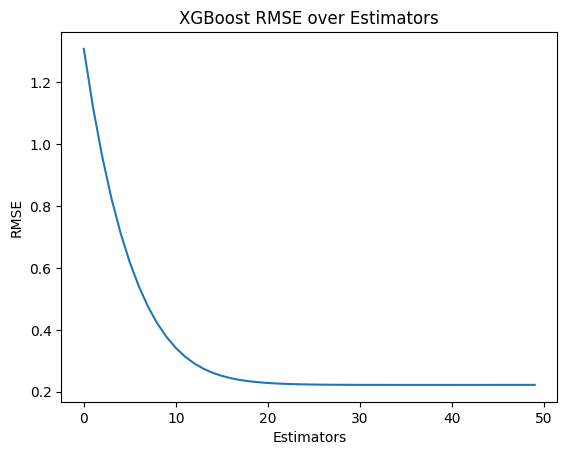

In [ ]:
# prompt: write a XGBoostfor the data_df predicting the label log view velocity, with 50 epochs. then graph the error on all the estimators

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import date
import time

# Assuming 'log_view_velocity' is your target variable
X = data_df[features]
y = data_df['log_view_velocity']

# Split the data into training and testing sets

data_df['trending_date'] = data_df['trending_date'].dt.tz_localize(None)
data_df['trending_date'] = pd.to_datetime(data_df['trending_date'])

train_df = data_df[(data_df['trending_date'] >= pd.Timestamp(date(2023, 1, 1))) & (data_df['trending_date'] <= pd.Timestamp(date(2023, 12, 31)))]
validation_df = data_df[(data_df['trending_date'] >= pd.Timestamp(date(2023, 12, 31))) & (data_df['trending_date'] <= pd.Timestamp(date(2024, 2, 18)))]
test_df = data_df[data_df['trending_date'] >= pd.Timestamp(date(2024, 2, 1))]


X_train = train_df[features]
y_train = train_df['log_view_velocity']

X_val = validation_df[features]
y_val = validation_df['log_view_velocity']

X_test = test_df[features]
y_test = test_df['log_view_velocity']

# Create an XGBoost regressor
model = xgb.XGBRegressor(n_estimators=50, objective='reg:squarederror', eta=0.15, max_depth=20)

# Train the model
# model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
model.fit(X_train.to_numpy(), y_train.to_numpy(), eval_set=[(X_test.to_numpy(), y_test.to_numpy())], verbose=True)

# Get the evaluation results from the training process
evals_result = model.evals_result()

# Extract the RMSE values for the test set
test_rmse = evals_result['validation_0']['rmse']
# ^re-run with this?

# Plot the RMSE values
plt.plot(test_rmse)
plt.xlabel('Estimators')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE over Estimators')
plt.show()


In [ ]:
data_df[features].dtypes = object

AttributeError: can't set attribute 'dtypes'

In [ ]:
# prompt: give me the trianing test and validation rmse from the model above

# Make predictions on the training, validation, and test sets
y_train_pred = model.predict(X_train.to_numpy()) # convert X_train to numpy.ndarray
y_val_pred = model.predict(X_val.to_numpy()) # convert X_val to numpy.ndarray
y_test_pred = model.predict(X_test.to_numpy()) # convert X_test to numpy.ndarray

# Calculate the RMSE for each set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Test RMSE: {test_rmse}")

Training RMSE: 0.23173599885296314
Validation RMSE: 0.23183508655513543
Test RMSE: 0.2222883518975482


In [ ]:
# prompt: plot the training and validation learning curves from the estimators above.

# Assuming 'model' is your trained XGBoost model and you have X_train, y_train, X_val, y_val

# Get training and validation loss during training
results = model.evals_result()
train_loss = results['validation_0']['rmse']
val_loss = results['validation_1']['rmse']

# Plot the training and validation curves
epochs = len(train_loss)
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss, label='Training RMSE')
plt.plot(range(epochs), val_loss, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and Validation Learning Curves')
plt.legend()
plt.show()

KeyError: 'validation_1'

                                 Feature  Importance
7                   days_since_published    0.972390
55         top_channel_category_20_Other    0.021890
18                category_encoded_Music    0.002102
15     category_encoded_Film & Animation    0.000459
14        category_encoded_Entertainment    0.000337
..                                   ...         ...
50  top_channel_category_20_Kentang_bayi    0.000000
51   top_channel_category_20_LittleGlove    0.000000
27     top_channel_category_20_AdeleVEVO    0.000000
53      top_channel_category_20_Mv Ryhan    0.000000
38       top_channel_category_20_Discord    0.000000

[77 rows x 2 columns]


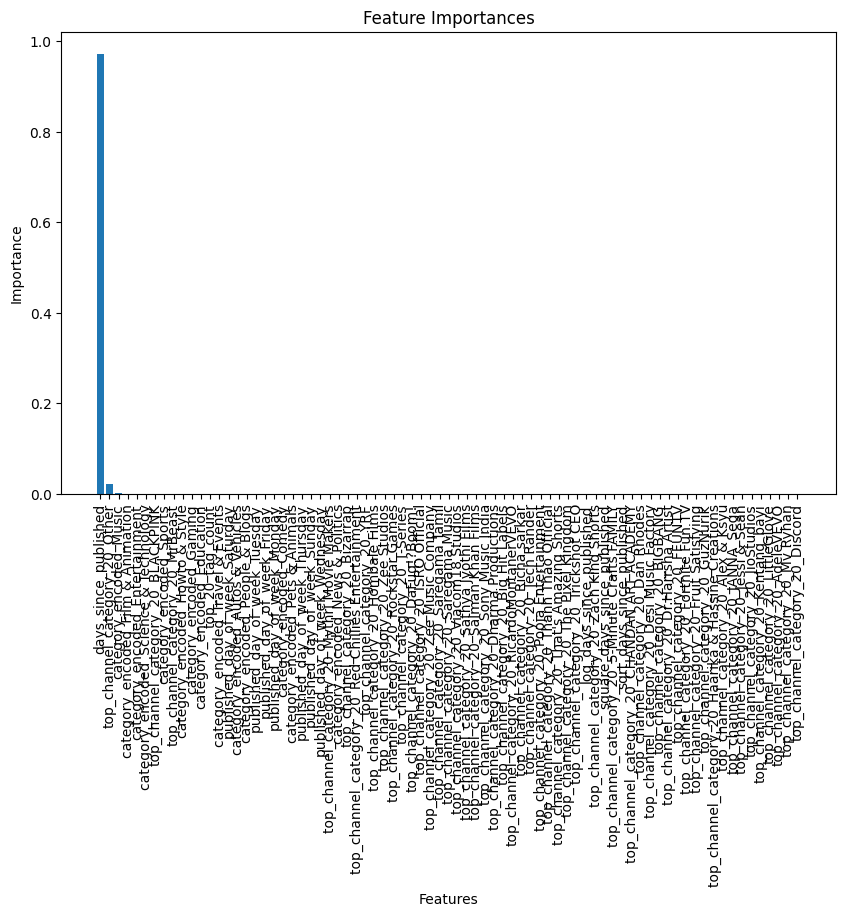

In [ ]:
# prompt: give me feature importance from the xgboost model above

# Get feature importances from the trained XGBoost model
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Print or display the feature importances
print(feature_importance_df)

# Optional: You can also plot the feature importances using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()


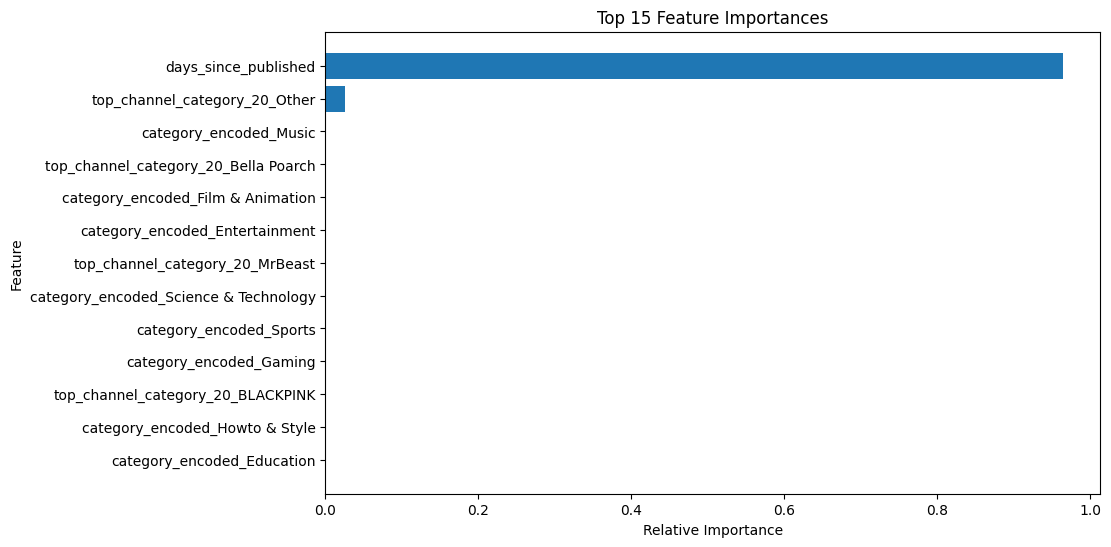

                                   Feature  Importance
7                     days_since_published    0.965138
143          top_channel_category_20_Other    0.026156
145          top_channel_category_20_Other    0.002373
18                  category_encoded_Music    0.001038
263   top_channel_category_20_Bella Poarch    0.000596
142          top_channel_category_20_Other    0.000492
15       category_encoded_Film & Animation    0.000430
14          category_encoded_Entertainment    0.000385
130        top_channel_category_20_MrBeast    0.000318
22   category_encoded_Science & Technology    0.000301
23                 category_encoded_Sports    0.000243
16                 category_encoded_Gaming    0.000185
42       top_channel_category_20_BLACKPINK    0.000181
17          category_encoded_Howto & Style    0.000152
13              category_encoded_Education    0.000141


In [ ]:
# prompt: list and plot the top 15 feature importances and their relative impotance vvlaue from the XGB above

# Get feature importances from the trained XGBoost model
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Select the top 15 features
top_15_features = feature_importance_df.head(15)

# Plot the top 15 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_15_features['Feature'], top_15_features['Importance'])
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()

# Print the top 15 feature importances with their values
print(top_15_features)

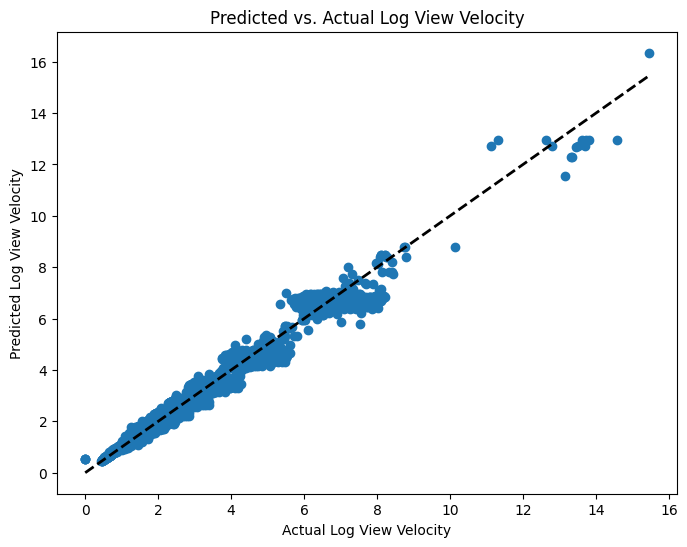

In [ ]:
# prompt: plot predicted vs actual values for the log view velocity from the model ran above

# Make predictions on the test set
y_pred = model.predict(X_test.to_numpy())

# Create a scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Log View Velocity")
plt.ylabel("Predicted Log View Velocity")
plt.title("Predicted vs. Actual Log View Velocity")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Add a diagonal line for reference
plt.show()


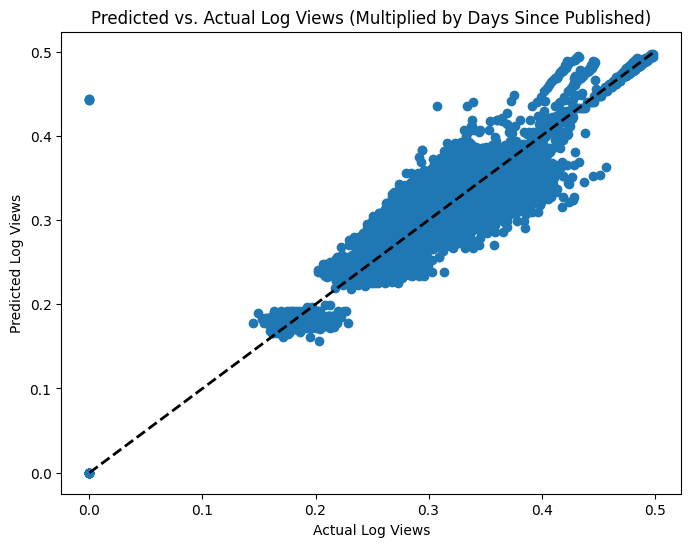

In [ ]:
# prompt: multply the acutaly and predictd values above by days sinc published and plot a scatterplot of acualv vs predicted log views

# Assuming 'y_test' and 'y_pred' are your actual and predicted log view velocities
# and 'data_df' is your DataFrame with 'days_since_published'

# Multiply actual and predicted values by days since published
actual_multiplied = y_test * data_df.loc[y_test.index, 'days_since_published']
predicted_multiplied = y_pred * data_df.loc[y_test.index, 'days_since_published']

# Create a scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(actual_multiplied, predicted_multiplied)
plt.xlabel("Actual Log Views")
plt.ylabel("Predicted Log Views")
plt.title("Predicted vs. Actual Log Views (Multiplied by Days Since Published)")
plt.plot([actual_multiplied.min(), actual_multiplied.max()], [actual_multiplied.min(), actual_multiplied.max()], 'k--', lw=2)  # Add a diagonal line for reference
plt.show()